In [1]:
import traceback

In [2]:
import os, random, trimesh, pickle, shutil, json, warnings
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Union
from sklearn.model_selection import train_test_split
from collections import defaultdict
warnings.filterwarnings('ignore')

In [3]:
# =============================================================================
# 메쉬 파일을 불러오는 역할
# =============================================================================
class MeshLoader:
    def __init__(self, data_dir: str, supported_formats=None):
        self.data_dir = Path(data_dir)
        self.supported_formats = supported_formats or ['.npy', '.obj', '.ply', '.stl', '.off']
        self.mesh_files = self._collect_mesh_files()

    def _collect_mesh_files(self) -> List[Path]:
        files = []
        for ext in self.supported_formats:
            files.extend(self.data_dir.glob(f"*{ext}"))
        return sorted(files)

    def get_all_file_paths(self) -> List[str]:
        return [str(f) for f in self.mesh_files]

    def load_mesh_data(self, file_path: str) -> Dict:
        try:
            print(f"🔍 로드 중: {file_path}")
            if file_path.endswith('.npy'):
                data = np.load(file_path, allow_pickle=True).item()
                return {
                    'vertices': np.array(data['vertices'], dtype=np.float32),
                    'faces': np.array(data['faces'], dtype=np.int32),
                    'file_path': file_path
                }

            # 그 외 포맷은 trimesh로 처리
            mesh = trimesh.load(file_path, force='mesh')
            if hasattr(mesh, 'geometry'):  # Scene인 경우
                mesh = list(mesh.geometry.values())[0]
            vertices = np.array(mesh.vertices, dtype=np.float32)
            faces = np.array(mesh.faces, dtype=np.int32)
            if len(vertices) == 0 or len(faces) == 0:
                raise ValueError("빈 메쉬")
            return {'vertices': vertices, 'faces': faces, 'file_path': file_path}

        except Exception as e:
            print(f"⚠️ 로딩 실패 {file_path}: {e}")
            return self._create_dummy_mesh()

    def _create_dummy_mesh(self) -> Dict:
        vertices = np.array([
            [0.0, 0.0, 0.0],
            [1.0, 0.0, 0.0],
            [0.5, 0.866, 0.0],
            [0.5, 0.289, 0.816]
        ], dtype=np.float32)
        faces = np.array([
            [0, 1, 2],
            [0, 2, 3],
            [0, 3, 1],
            [1, 3, 2]
        ], dtype=np.int32)
        return {'vertices': vertices, 'faces': faces, 'file_path': 'dummy'}


In [4]:
class MeshPreprocessor:
    def __init__(self, max_vertices: int, max_faces: int):
        self.max_vertices = max_vertices
        self.max_faces = max_faces

    def preprocess(self, mesh_data: Dict) -> Dict:
        vertices = self._normalize_vertices(mesh_data['vertices'])
        vertices, faces = self._resize_mesh(vertices, mesh_data['faces'])
        normals = self._compute_face_normals(vertices, faces)
        features = self._compute_edge_features(vertices, faces)
        
        print("샘플 features:")
        print(features[:5])
        print("면 개수:", len(faces))
        print("정점 평균 거리:", np.mean(np.linalg.norm(vertices, axis=1)))

        return {
            'vertices': tf.constant(vertices, dtype=tf.float32),
            'faces': tf.constant(faces, dtype=tf.int32),
            'normals': tf.constant(normals, dtype=tf.float32),
            'features': tf.constant(features, dtype=tf.float32)
        }

    def _normalize_vertices(self, vertices: np.ndarray) -> np.ndarray:
        center = vertices.mean(axis=0)
        vertices -= center
        max_dist = np.max(np.linalg.norm(vertices, axis=1))
        if max_dist > 0:
            vertices /= max_dist
        print("원본 vertex 예시:", vertices[:3])
        print("normalize 후:", vertices[:3])
        return vertices

    def _resize_mesh(self, vertices: np.ndarray, faces: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        n_vertices = len(vertices)
        n_faces = len(faces)
        if n_vertices > self.max_vertices:
            indices = np.linspace(0, n_vertices-1, self.max_vertices, dtype=int)
            vertices = vertices[indices]
            faces = self._remap_faces(faces, indices)
        elif n_vertices < self.max_vertices:
            padding = np.tile(vertices[-1:], (self.max_vertices - n_vertices, 1)) if n_vertices else np.zeros((self.max_vertices, 3), np.float32)
            vertices = np.vstack([vertices, padding])
        if len(faces) > self.max_faces:
            indices = np.linspace(0, len(faces)-1, self.max_faces, dtype=int)
            faces = faces[indices]
        elif len(faces) < self.max_faces:
            padding = np.tile(faces[-1:], (self.max_faces - len(faces), 1)) if len(faces) else np.zeros((self.max_faces, 3), dtype=np.int32)
            faces = np.vstack([faces, padding])
        return vertices, faces

    def _remap_faces(self, faces: np.ndarray, vertex_indices: np.ndarray) -> np.ndarray:
        old_to_new = {old: new for new, old in enumerate(vertex_indices)}
        valid_faces = [[old_to_new[v] for v in face] for face in faces if all(v in old_to_new for v in face)]
        return np.array(valid_faces, dtype=np.int32) if valid_faces else np.zeros((0, 3), dtype=np.int32)

    def _compute_face_normals(self, vertices: np.ndarray, faces: np.ndarray) -> np.ndarray:
        normals = []
        for face in faces:
            if len(np.unique(face)) == 3:
                v0, v1, v2 = vertices[face]
                normal = np.cross(v1 - v0, v2 - v0)
                norm = np.linalg.norm(normal)
                normals.append(normal / norm if norm > 1e-8 else [0.0, 0.0, 1.0])
            else:
                normals.append([0.0, 0.0, 1.0])
        while len(normals) < self.max_faces:
            normals.append([0.0, 0.0, 1.0])
        return np.array(normals[:self.max_faces], dtype=np.float32)

    def _compute_edge_features(self, vertices: np.ndarray, faces: np.ndarray) -> np.ndarray:
        features = []
        for face in faces:
            if len(np.unique(face)) != 3:
                # 비정상 face: 중복된 vertex
                features.append([0.0, 0.0, 1.0, 0.0, 0.0])
                continue

            v0, v1, v2 = vertices[face]

            # Edges
            e0 = v1 - v0
            e1 = v2 - v1
            e2 = v0 - v2

            # Edge lengths
            len0 = np.linalg.norm(e0)
            len1 = np.linalg.norm(e1)
            len2 = np.linalg.norm(e2)

            # Area (Heron's formula for better numerical stability)
            s = 0.5 * (len0 + len1 + len2)
            area = max(np.sqrt(max(s * (s - len0) * (s - len1) * (s - len2), 0)), 1e-12)

            # Perimeter
            perimeter = len0 + len1 + len2

            # Aspect Ratio (based on triangle quality metric)
            aspect_ratio = max(len0, len1, len2) / (min(len0, len1, len2) + 1e-8)

            # Angle between two edges (robustly)
            cos_angle = np.dot(e0, -e2) / ((len0 * len2) + 1e-8)
            angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))

            # Centroid distance from origin
            centroid = (v0 + v1 + v2) / 3.0
            centroid_distance = np.linalg.norm(centroid)

            features.append([area, perimeter, aspect_ratio, angle, centroid_distance])

        # Padding
        while len(features) < self.max_faces:
            features.append([0.0, 0.0, 1.0, 0.0, 0.0])

        return np.array(features[:self.max_faces], dtype=np.float32)


In [5]:
class MeshDataManager:
    def __init__(self, source_dir: str, training_dir: str, max_vertices: int = 5000, max_faces: int = 10000):
        self.source_dir = Path(source_dir)
        self.training_dir = Path(training_dir)
        self.max_vertices = max_vertices
        self.max_faces = max_faces

        # 학습 데이터 디렉토리 구조 생성
        self.train_dir = self.training_dir / "train/mesh"
        self.val_dir = self.training_dir / "val/mesh"
        self.test_dir = self.training_dir / "test/mesh"

        for dir_path in [self.training_dir, self.train_dir, self.val_dir, self.test_dir]:
            dir_path.mkdir(parents=True, exist_ok=True)

        self.train_files: List[str] = []
        self.val_files: List[str] = []
        self.test_files: List[str] = []

    def prepare_training_data(self, split_ratio=(0.7, 0.2, 0.1), seed=42):
        print("📁 학습 데이터 준비 중...")
        random.seed(seed)

        files = list(self.source_dir.glob("*"))
        grouped = defaultdict(dict)

        # 그룹핑: {id}_{type}.{ext}
        for f in files:
            base = f.stem
            if "_" not in base:
                continue
            parts = base.split("_")
            sample_id = parts[0]
            label_type = parts[1]
            grouped[f"{sample_id}_{label_type}"][f.suffix] = f

        paired_ids = set(k.rsplit("_", 1)[0] for k in grouped)
        pairs = []
        for sample_id in paired_ids:
            ab_key = f"{sample_id}_abnormal"
            no_key = f"{sample_id}_normal"
            if ab_key in grouped and no_key in grouped:
                pairs.append((grouped[ab_key], grouped[no_key]))

        print(f"🔗 총 쌍: {len(pairs)} (abnormal + normal)")

        random.shuffle(pairs)
        total = len(pairs)
        n_train = int(split_ratio[0] * total)
        n_val = int(split_ratio[1] * total)

        splits = {
            "train": pairs[:n_train],
            "val": pairs[n_train:n_train+n_val],
            "test": pairs[n_train+n_val:]
        }

        for split_name, pair_list in splits.items():
            mesh_path = self.training_dir / split_name / "mesh"
            label_path = self.training_dir / split_name / "label"
            mesh_path.mkdir(parents=True, exist_ok=True)
            label_path.mkdir(parents=True, exist_ok=True)

            for ab_dict, no_dict in pair_list:
                for data_dict in [ab_dict, no_dict]:
                    for ext in ['.obj', '.npy']:
                        if ext in data_dict:
                            dst_dir = mesh_path if ext == ".obj" else label_path
                            shutil.copy2(data_dict[ext], dst_dir / data_dict[ext].name)

            print(f"✅ {split_name}: {len(pair_list)*2}개 파일 복사 완료")

        with open(self.training_dir / "split_info.json", "w") as f:
            json.dump({k: len(v) for k, v in splits.items()}, f, indent=2)

        print("🎉 모든 파일 분할 완료")
        return True

In [6]:
class MeshDatasetTF:
    def __init__(self, data_dir: str, max_vertices: int = 2048, max_faces: int = 4096):
        self.source_dir = Path(data_dir)
        self.max_vertices = max_vertices
        self.max_faces = max_faces

        self.loader = MeshLoader(str(self.source_dir))
        self.preprocessor = MeshPreprocessor(max_vertices, max_faces)
        self.mesh_files = self.loader.get_all_file_paths()

    def _load_and_process(self, file_path_tensor):
        file_path = file_path_tensor.numpy().decode('utf-8')

        raw_data = self.loader.load_mesh_data(file_path)
        mesh_data = self.preprocessor.preprocess(raw_data)

        return tuple(tf.convert_to_tensor(mesh_data[k], dtype=tf.float32 if k != 'faces' else tf.int32)
                     for k in ['vertices', 'faces', 'normals', 'features'])

    def create_dataset(self, batch_size=8, shuffle=True, prefetch_buffer=tf.data.AUTOTUNE):
        if len(self.mesh_files) == 0:
            print(f"⚠️ No mesh files found in: {self.source_dir}")
            return tf.data.Dataset.from_tensor_slices({}).take(0)

        ds = tf.data.Dataset.from_tensor_slices(self.mesh_files)

        if shuffle and len(self.mesh_files) > 1:
            ds = ds.shuffle(len(self.mesh_files))

        ds = ds.map(lambda path: tf.py_function(
            self._load_and_process, inp=[path],
            Tout=[tf.float32, tf.int32, tf.float32, tf.float32]
        ))

        ds = ds.map(lambda v, f, n, feat: {
            'vertices': tf.reshape(v, [self.max_vertices, 3]),
            'faces': tf.reshape(f, [self.max_faces, 3]),
            'normals': tf.reshape(n, [self.max_faces, 3]),
            'features': tf.reshape(feat, [self.max_faces, 5]),
        })

        return ds.batch(batch_size).prefetch(prefetch_buffer)
    
def setup_environment(source_dir: str, training_dir: str, 
                      max_vertices: int = 1024, max_faces: int = 2048):
    print("🚀 학습 환경 설정 시작")
    
    data_manager = MeshDataManager(
        source_dir=source_dir,
        training_dir=training_dir,
        max_vertices=max_vertices,
        max_faces=max_faces
    )
    
    if not data_manager.prepare_training_data():
        return None

    summary = {
        'setup_completed': True,
        'source_dir': source_dir,
        'training_dir': training_dir,
        'max_vertices': max_vertices,
        'max_faces': max_faces
    }
    
    with open(Path(training_dir) / "setup_summary.json", 'w') as f:
        json.dump(summary, f, indent=2)
    
    print("✅ 학습 환경 설정 완료!")
    print(f"📁 학습 데이터 디렉토리: {training_dir}")
    
    return data_manager

def create_datasets(training_dir: str, batch_size: int = 8, 
                    max_vertices: int = 5000, max_faces: int = 10000):
    print("🔄 TensorFlow 데이터셋 생성 중...")
    
    training_path = Path(training_dir)

    train_files = list((training_path / "train" / "mesh").glob("*.*"))
    val_files = list((training_path / "val" / "mesh").glob("*.*"))
    test_files = list((training_path / "test" / "mesh").glob("*.*"))

    print(f"📊 데이터 현황:")
    print(f"  - 학습: {len(train_files)}개 파일")
    print(f"  - 검증: {len(val_files)}개 파일")
    print(f"  - 테스트: {len(test_files)}개 파일")

    train_dataset = MeshDatasetTF(
        data_dir=str(training_path / "train" / "mesh"),
        max_vertices=max_vertices,
        max_faces=max_faces
    ).create_dataset(batch_size=batch_size, shuffle=True)

    val_dataset = MeshDatasetTF(
        data_dir=str(training_path / "val" / "mesh"),
        max_vertices=max_vertices,
        max_faces=max_faces
    ).create_dataset(batch_size=batch_size, shuffle=False)

    test_dataset = MeshDatasetTF(
        data_dir=str(training_path / "test" / "mesh"),
        max_vertices=max_vertices,
        max_faces=max_faces
    ).create_dataset(batch_size=batch_size, shuffle=False)

    print("✅ 데이터셋 생성 완료!")
    print(f"  - 배치 크기: {batch_size}")
    print(f"  - 최대 정점 수: {max_vertices}")
    print(f"  - 최대 면 수: {max_faces}")

    return train_dataset, val_dataset, test_dataset

In [7]:
def setup_environment(source_dir: str, training_dir: str, 
                      max_vertices: int = 1024, max_faces: int = 2048):
    print("🚀 학습 환경 설정 시작")
    
    data_manager = MeshDataManager(
        source_dir=source_dir,
        training_dir=training_dir,
        max_vertices=max_vertices,
        max_faces=max_faces
    )
    
    if not data_manager.prepare_training_data():
        return None

    summary = {
        'setup_completed': True,
        'source_dir': source_dir,
        'training_dir': training_dir,
        'max_vertices': max_vertices,
        'max_faces': max_faces
    }
    
    with open(Path(training_dir) / "setup_summary.json", 'w') as f:
        json.dump(summary, f, indent=2)
    
    print("✅ 학습 환경 설정 완료!")
    print(f"📁 학습 데이터 디렉토리: {training_dir}")
    
    return data_manager

def create_datasets(training_dir: str, batch_size: int = 8, 
                    max_vertices: int = 1024, max_faces: int = 2048):
    print("🔄 TensorFlow 데이터셋 생성 중...")
    
    training_path = Path(training_dir)

    train_files = list((training_path / "train" / "mesh").glob("*.*"))
    val_files = list((training_path / "val" / "mesh").glob("*.*"))
    test_files = list((training_path / "test" / "mesh").glob("*.*"))

    print(f"📊 데이터 현황:")
    print(f"  - 학습: {len(train_files)}개 파일")
    print(f"  - 검증: {len(val_files)}개 파일")
    print(f"  - 테스트: {len(test_files)}개 파일")

    train_dataset = MeshDatasetTF(
        data_dir=str(training_path / "train" / "mesh"),
        max_vertices=max_vertices,
        max_faces=max_faces
    ).create_dataset(batch_size=batch_size, shuffle=True)

    val_dataset = MeshDatasetTF(
        data_dir=str(training_path / "val" / "mesh"),
        max_vertices=max_vertices,
        max_faces=max_faces
    ).create_dataset(batch_size=batch_size, shuffle=False)

    test_dataset = MeshDatasetTF(
        data_dir=str(training_path / "test" / "mesh"),
        max_vertices=max_vertices,
        max_faces=max_faces
    ).create_dataset(batch_size=batch_size, shuffle=False)

    print("✅ 데이터셋 생성 완료!")
    print(f"  - 배치 크기: {batch_size}")
    print(f"  - 최대 정점 수: {max_vertices}")
    print(f"  - 최대 면 수: {max_faces}")

    return train_dataset, val_dataset, test_dataset

특성 분석 및 시각화 클래스

In [8]:
# =============================================================================
# 특성 분석 및 시각화 클래스
# =============================================================================

class MeshFeatureAnalyzer:
    def __init__(self, dataset: MeshDatasetTF):
        self.dataset = dataset
        self.feature_columns = ['area', 'perimeter', 'aspect_ratio', 'angle', 'centroid_distance']
        
    def analyze_features(self, dirs: List[str], num_samples: Union[int, None] = None) -> pd.DataFrame:
        print(f"📊 {num_samples}개 샘플의 특성을 분석중...")

        all_features = []
        total_dirs = len(dirs)

        for d_idx, dir_path in enumerate(dirs):
            print(f"\n📂 [{d_idx+1}/{total_dirs}] 디렉토리 분석 중: {dir_path}")
            loader = MeshLoader(dir_path)
            file_paths = loader.get_all_file_paths()

            sampled_paths = file_paths if num_samples is None or num_samples > len(file_paths) else file_paths[:num_samples]
            print(f"  🔢 총 {len(sampled_paths)}개 파일 분석")

            preprocessor = MeshPreprocessor(self.dataset.max_vertices, self.dataset.max_faces)

            for i, file_path in enumerate(sampled_paths):
                if i % 10 == 0:
                    print(f"  진행률: {i+1}/{len(sampled_paths)}")

                try:
                    raw_data = self.dataset.loader.load_mesh_data(file_path)
                    processed_data = self.dataset.preprocessor.preprocess(raw_data)
                    features = processed_data['features'].numpy()

                    for face_idx, feature in enumerate(features):
                        if not np.all(feature == 0):
                            feature_dict = {
                                'file_path': Path(file_path).name,
                                'face_idx': face_idx,
                                'area': feature[0],
                                'perimeter': feature[1],
                                'aspect_ratio': feature[2],
                                'angle': feature[3],
                                'centroid_distance': feature[4],
                                'source_dir': Path(dir_path).name
                            }
                            all_features.append(feature_dict)

                except Exception as e:
                    print(f"⚠️ {file_path} 분석 실패: {e}")
                    continue

        df = pd.DataFrame(all_features)
        print(f"\n✅ 총 {len(df)}개의 face 특성을 분석했습니다.")
        return df
    
    def visualize_features(self, df: pd.DataFrame, save_plots: bool = False):
        print("📈 특성 데이터 시각화 중...")
        print("🧪 현재 컬럼:", df.columns.tolist())
        print("📭 DataFrame 비어있는가?", df.empty)
        print(f"총 분석된 feature 개수: {len(df)}")

        print("\n=== 기본 통계 정보 ===")
        print(df[self.feature_columns].describe())

        print("\n=== 결측치 확인 ===")
        print(df[self.feature_columns].isnull().sum())

        print("\n=== 무한값 확인 ===")
        for col in self.feature_columns:
            print(f"{col}: {np.isinf(df[col]).sum()}개의 무한값")

        plt.style.use('default')

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('메쉬 특성 분포 히스토그램', fontsize=16)

        for i, col in enumerate(self.feature_columns):
            row, col_idx = divmod(i, 3)
            q1 = df[col].quantile(0.01)
            q99 = df[col].quantile(0.99)
            filtered = df[col][(df[col] >= q1) & (df[col] <= q99)]
            axes[row, col_idx].hist(filtered, bins=50, alpha=0.7, edgecolor='black')
            axes[row, col_idx].set_title(col)
            axes[row, col_idx].set_xlabel('값')
            axes[row, col_idx].set_ylabel('빈도')
            axes[row, col_idx].grid(True, alpha=0.3)

        fig.delaxes(axes[1, 2])
        plt.tight_layout()
        plt.show()

        fig, axes = plt.subplots(1, 5, figsize=(20, 6))
        fig.suptitle('메쉬 특성 박스플롯', fontsize=16)

        for i, col in enumerate(self.feature_columns):
            data = df[col][df[col] > 0] if (df[col] > 0).any() else df[col]
            axes[i].boxplot(data, vert=True)
            if (df[col] > 0).any():
                axes[i].set_yscale('log')
            axes[i].set_title(col)
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 8))
        sns.heatmap(df[self.feature_columns].corr(), annot=True, cmap='coolwarm', center=0, square=True, fmt='.3f')
        plt.title('메쉬 특성 간 상관관계')
        plt.tight_layout()
        plt.show()

        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('주요 특성 간 관계', fontsize=16)

        axes[0, 0].scatter(df['area'], df['perimeter'], alpha=0.5, s=1)
        axes[0, 0].set_xlabel('Area')
        axes[0, 0].set_ylabel('Perimeter')
        axes[0, 0].set_title('Area vs Perimeter')

        axes[0, 1].scatter(df['aspect_ratio'], df['angle'], alpha=0.5, s=1)
        axes[0, 1].set_xlabel('Aspect Ratio')
        axes[0, 1].set_ylabel('Angle')
        axes[0, 1].set_title('Aspect Ratio vs Angle')

        axes[1, 0].scatter(df['area'], df['centroid_distance'], alpha=0.5, s=1)
        axes[1, 0].set_xlabel('Area')
        axes[1, 0].set_ylabel('Centroid Distance')
        axes[1, 0].set_title('Area vs Centroid Distance')

        axes[1, 1].scatter(df['perimeter'], df['aspect_ratio'], alpha=0.5, s=1)
        axes[1, 1].set_xlabel('Perimeter')
        axes[1, 1].set_ylabel('Aspect Ratio')
        axes[1, 1].set_title('Perimeter vs Aspect Ratio')

        for ax in axes.flat:
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def detect_anomalies(self, df: pd.DataFrame) -> pd.DataFrame:
        print("\n🔍 이상치 탐지 중...")

        anomalies = []
        for col in self.feature_columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR

            outliers = df[(df[col] < lower) | (df[col] > upper)]
            print(f"{col}: {len(outliers)}개의 이상치 ({len(outliers) / len(df) * 100:.2f}%)")

            for _, row in outliers.iterrows():
                anomalies.append({
                    'file_path': row['file_path'],
                    'face_idx': row['face_idx'],
                    'feature': col,
                    'value': row[col],
                    'lower_bound': lower,
                    'upper_bound': upper
                })

        return pd.DataFrame(anomalies)

In [9]:
def setup_environment(source_dir: str, training_dir: str, 
                      max_vertices: int = 1024, max_faces: int = 2048):
    """학습 환경 설정 및 데이터 준비"""
    print("🚀 학습 환경 설정 시작")
    
    # 1. 데이터 매니저 생성
    data_manager = MeshDataManager(
        source_dir=source_dir,
        training_dir=training_dir,
        max_vertices=max_vertices,
        max_faces=max_faces
    )
    
    # 2. 학습 데이터 준비
    if not data_manager.prepare_training_data():
        return None
    
    # 3. 특성 분석
    analyzer = MeshFeatureAnalyzer(
        MeshDatasetTF(
            data_dir=str(Path(training_dir) / "train" / "mesh"),
            max_vertices=max_vertices,
            max_faces=max_faces
        )
    )
    
    train_dir = os.path.join(training_dir, "train", "mesh")
    val_dir = os.path.join(training_dir, "val", "mesh")

    feature_df = analyzer.analyze_features(
        dirs=[train_dir, val_dir],
        num_samples=None
    )

    analyzer.visualize_features(feature_df)
    anomalies_df = analyzer.detect_anomalies(feature_df)
    print(f"\n❗ 이상치 샘플 수: {len(anomalies_df)}개")
    
    # 4. 요약 정보 저장
    summary = {
        'setup_completed': True,
        'source_dir': source_dir,
        'training_dir': training_dir,
        'max_vertices': max_vertices,
        'max_faces': max_faces,
        'datasets_analyzed': list(feature_df.keys()),
        'total_features_analyzed': len(feature_df)
    }
    
    with open(Path(training_dir) / "setup_summary.json", 'w') as f:
        json.dump(summary, f, indent=2)
    
    print("✅ 학습 환경 설정 완료!")
    print(f"📁 학습 데이터 디렉토리: {training_dir}")
    
    return data_manager


def create_datasets(training_dir: str, batch_size: int = 8, 
                    max_vertices: int = 1024, max_faces: int = 2048):
    """학습용 TensorFlow 데이터셋 생성"""
    print("🔄 TensorFlow 데이터셋 생성 중...")

    training_path = Path(training_dir)

    # 데이터셋 생성
    train_dataset = MeshDatasetTF(
        data_dir=str(training_path / "train" / "mesh"),
        max_vertices=max_vertices,
        max_faces=max_faces
    ).create_dataset(batch_size=batch_size, shuffle=True)

    val_dataset = MeshDatasetTF(
        data_dir=str(training_path / "val" / "mesh"),
        max_vertices=max_vertices,
        max_faces=max_faces
    ).create_dataset(batch_size=batch_size, shuffle=False)

    test_dataset = MeshDatasetTF(
        data_dir=str(training_path / "test" / "mesh"),
        max_vertices=max_vertices,
        max_faces=max_faces
    ).create_dataset(batch_size=batch_size, shuffle=False)

    print("✅ 데이터셋 생성 완료!")
    print(f"  - 배치 크기: {batch_size}")
    print(f"  - 최대 정점 수: {max_vertices}")
    print(f"  - 최대 면 수: {max_faces}")

    return train_dataset, val_dataset, test_dataset


메쉬 데이터 학습 환경 설정
🔧 하드웨어 설정: 정점=1024, 면=2048, 배치=8
🚀 학습 환경 설정 시작
📁 학습 데이터 준비 중...
🔗 총 쌍: 175 (abnormal + normal)
✅ train: 244개 파일 복사 완료
✅ val: 70개 파일 복사 완료
✅ test: 36개 파일 복사 완료
🎉 모든 파일 분할 완료
📊 None개 샘플의 특성을 분석중...

📂 [1/2] 디렉토리 분석 중: C:/Users/konyang/Desktop/MeshCNN_TF/data\train\mesh
  🔢 총 350개 파일 분석
  진행률: 1/350
🔍 로드 중: C:\Users\konyang\Desktop\MeshCNN_TF\data\train\mesh\A0083_abnormal.obj
원본 vertex 예시: [[-0.54120797  0.33599737 -0.23505114]
 [-0.5361725   0.33599737 -0.24008664]
 [-0.5361725   0.33096188 -0.23505114]]
normalize 후: [[-0.54120797  0.33599737 -0.23505114]
 [-0.5361725   0.33599737 -0.24008664]
 [-0.5361725   0.33096188 -0.23505114]]
샘플 features:
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
면 개수: 2048
정점 평균 거리: 0.5585939
🔍 로드 중: C:\Users\konyang\Desktop\MeshCNN_TF\data\train\mesh\A0083_normal.obj
원본 vertex 예시: [[-0.54093415  0.33548525 -0.23424283]
 [-0.53590167  0.33548525 -0.23927535]
 [-0.53590167  0.33045274 -0.23424283]]


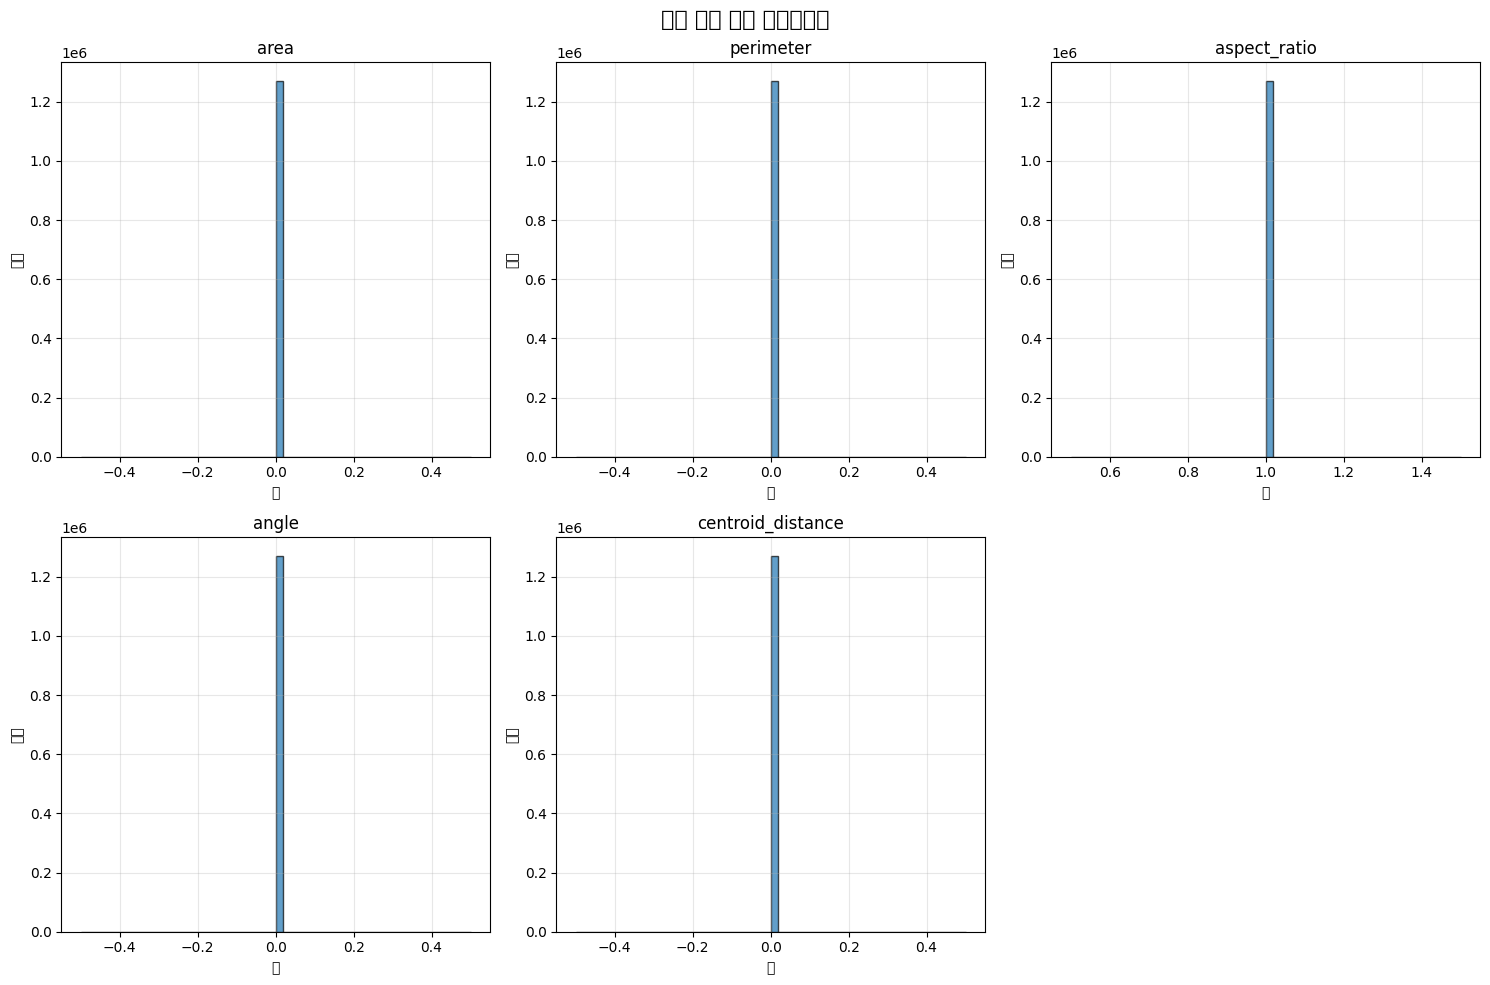

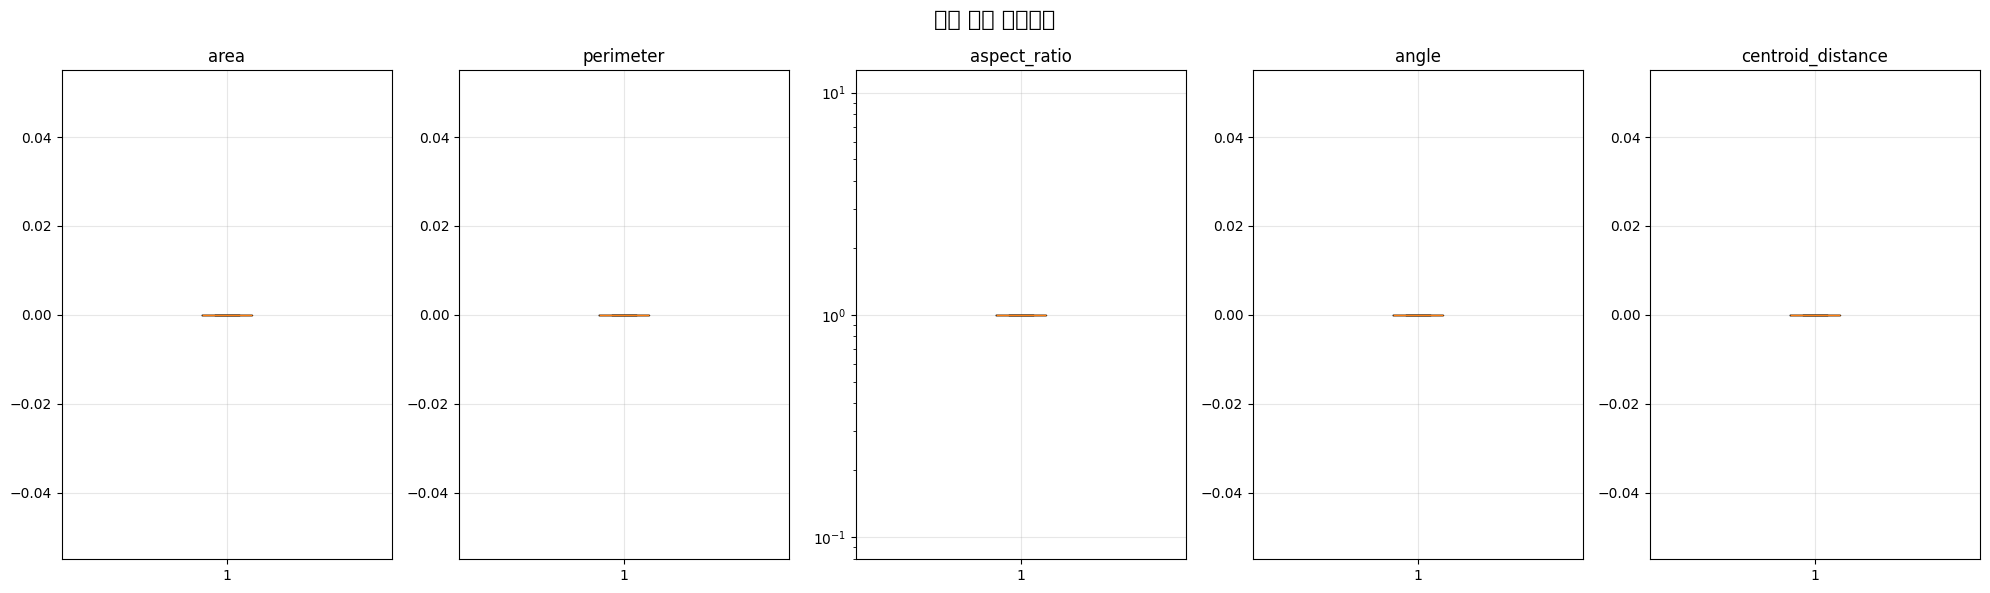

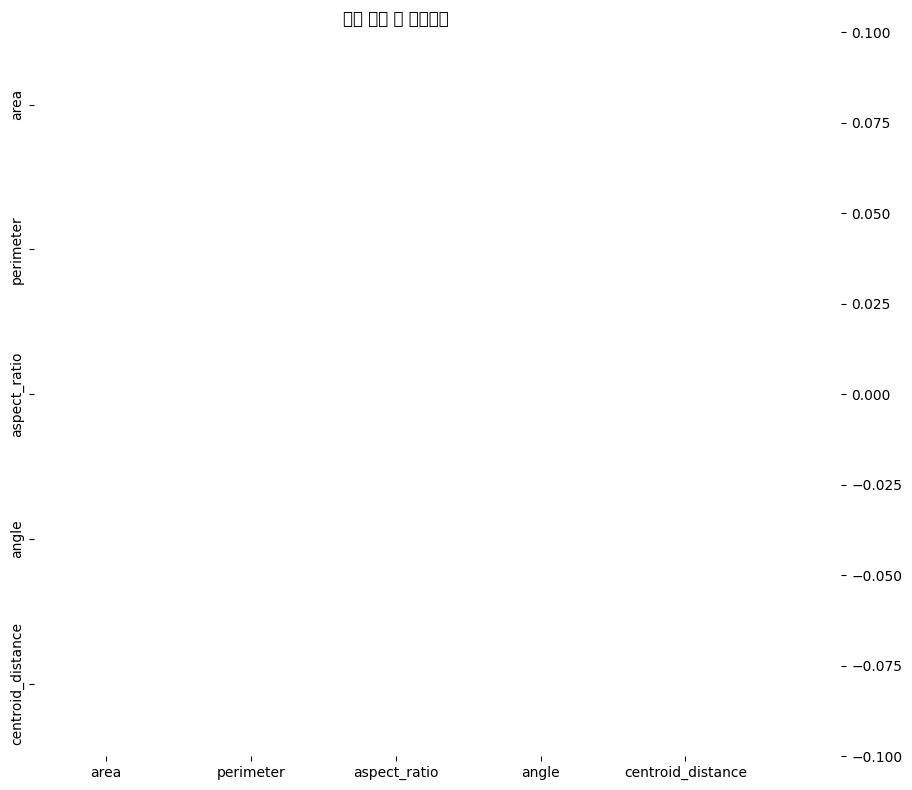

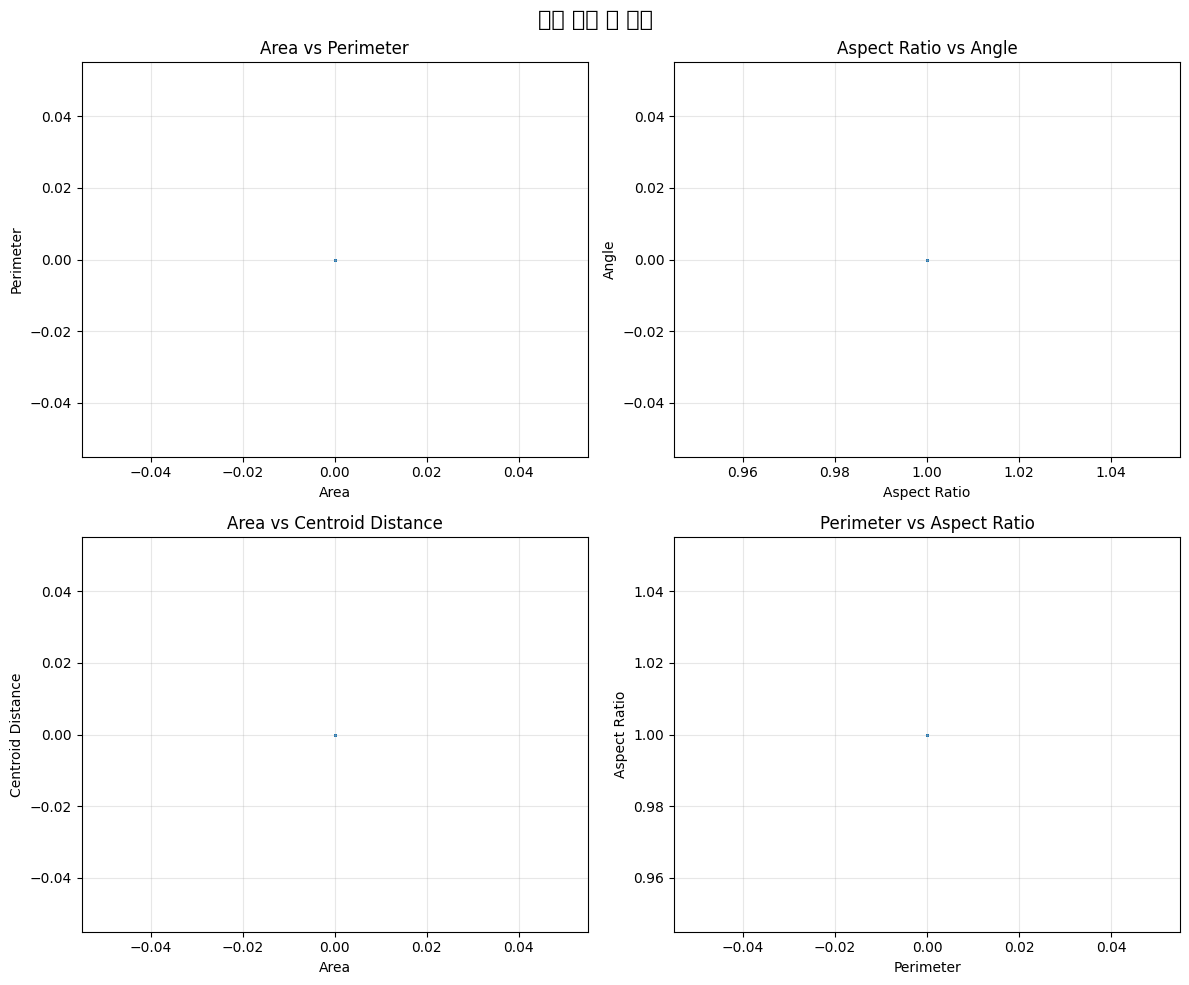


🔍 이상치 탐지 중...
area: 0개의 이상치 (0.00%)
perimeter: 0개의 이상치 (0.00%)
aspect_ratio: 0개의 이상치 (0.00%)
angle: 0개의 이상치 (0.00%)
centroid_distance: 0개의 이상치 (0.00%)

❗ 이상치 샘플 수: 0개
✅ 학습 환경 설정 완료!
📁 학습 데이터 디렉토리: C:/Users/konyang/Desktop/MeshCNN_TF/data
🔄 TensorFlow 데이터셋 생성 중...
✅ 데이터셋 생성 완료!
  - 배치 크기: 8
  - 최대 정점 수: 1024
  - 최대 면 수: 2048

🔍 데이터셋 확인:
🔍 로드 중: C:\Users\konyang\Desktop\MeshCNN_TF\data\train\mesh\A0185_abnormal.obj
원본 vertex 예시: [[-0.5339162  -0.1960997  -0.7447367 ]
 [-0.5290117  -0.1960997  -0.74964106]
 [-0.5290117  -0.20100412 -0.7447367 ]]
normalize 후: [[-0.5339162  -0.1960997  -0.7447367 ]
 [-0.5290117  -0.1960997  -0.74964106]
 [-0.5290117  -0.20100412 -0.7447367 ]]
샘플 features:
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
면 개수: 2048
정점 평균 거리: 0.55457896
🔍 로드 중: C:\Users\konyang\Desktop\MeshCNN_TF\data\train\mesh\Z079_normal.obj
원본 vertex 예시: [[-0.47289544 -0.35476023 -0.76008505]
 [-0.4680653  -0.35476023 -0.76491517]
 [-0.4680653  -

In [10]:
# =============================================================================
# 메인 실행 부분
# =============================================================================

if __name__ == "__main__":
    # 설정
    BASE_DIR = "C:/Users/konyang/Desktop/data(진짜임)/dataSet"
    SOURCE_DIR = BASE_DIR  # 원본 메쉬 파일 디렉토리
    TRAINING_DIR = "C:/Users/konyang/Desktop/MeshCNN_TF/data"  # 학습 데이터 저장 디렉토리

    # 학습 설정 (저사양 기준)
    MAX_VERTICES = 1024
    MAX_FACES = 2048
    BATCH_SIZE = 8

    print("=" * 60)
    print("메쉬 데이터 학습 환경 설정")
    print("=" * 60)
    print(f"🔧 하드웨어 설정: 정점={MAX_VERTICES}, 면={MAX_FACES}, 배치={BATCH_SIZE}")

    # 1. 학습 환경 설정
    data_manager = setup_environment(
        source_dir=SOURCE_DIR,
        training_dir=TRAINING_DIR,
        max_vertices=MAX_VERTICES,
        max_faces=MAX_FACES
    )

    if data_manager is None:
        print("❌ 학습 환경 설정 실패")
        exit(1)

    # 2. 학습용 데이터셋 생성
    train_ds, val_ds, test_ds = create_datasets(
        training_dir=TRAINING_DIR,
        batch_size=BATCH_SIZE,
        max_vertices=MAX_VERTICES,
        max_faces=MAX_FACES
    )

    # 3. 데이터셋 확인
    print("\n🔍 데이터셋 확인:")
    for batch in train_ds.take(1):
        print(f"Batch shape:")
        for key, value in batch.items():
            print(f"  {key}: {value.shape}")

    print("\n🎉 모든 준비 완료! 이제 학습을 시작할 수 있습니다.")
    print(f"📂 학습 데이터: {TRAINING_DIR}")
    print(f"💡 설정을 변경하려면 위의 MAX_VERTICES, MAX_FACES, BATCH_SIZE 값을 조정하세요.")
